In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

In [30]:
all_df = pd.read_csv('covid-19-all.csv' ,  names=['Country', 'Province', 'Lat', 'Long', 'Confirmed', 'Recovered', 'Deaths', 'Date'], header=0)
all_df.drop(['Lat', 'Long'], inplace = True, axis=1)

In [31]:
grouped_sl = all_df[all_df['Country'] == "Sri Lanka"].reset_index()
grouped_sl.head()

,index,Country,Province,Confirmed,Recovered,Deaths,Date
0,263,Sri Lanka,NaN,1.0,NaN,NaN,2020-01-27
1,315,Sri Lanka,NaN,1.0,NaN,NaN,2020-01-28
2,367,Sri Lanka,NaN,1.0,NaN,NaN,2020-01-29
3,422,Sri Lanka,NaN,1.0,NaN,NaN,2020-01-30
4,488,Sri Lanka,NaN,1.0,NaN,NaN,2020-01-31


In [32]:
grouped_sl = pd.pivot_table(grouped_sl, values=['Confirmed', 'Recovered','Deaths'], index=['Date'], aggfunc=np.sum)
grouped_sl.tail()

,Confirmed,Deaths,Recovered
Date,,,
2020-04-04,166.0,5.0,27.0
2020-04-05,176.0,5.0,33.0
2020-04-06,178.0,5.0,38.0
2020-04-07,185.0,6.0,42.0
2020-04-08,189.0,7.0,44.0


##### x_0 = the inflection point
##### N = the curve's maximum value, and
##### k = growth rate or steepness of the curve.

#### For reference: https://en.wikipedia.org/wiki/Logistic_function.
###### Actually, the logistic function is just a solution for the following first-order, non-linear ordinary differential equation where f(0) = 0.5:

## Logistic Curve

In [40]:
x_data = range(len(grouped_sl.index))
y_data = grouped_sl['Confirmed']



# I will want x_data to be the number of days since first confirmed and the y_data to be the confirmed data. This will be the data we use to fit a logistic curve
def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=50000)
estimated_k, estimated_x_0, ymax= popt


# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0
y_fitted = log_curve(x_data, k, x_0, ymax)
print(k, x_0, ymax)
y_data.tail()

0.18452043075006724 57.667168929748 191.05149967909713


Date
2020-04-04    166.0
2020-04-05    176.0
2020-04-06    178.0
2020-04-07    185.0
2020-04-08    189.0
Name: Confirmed, dtype: float64

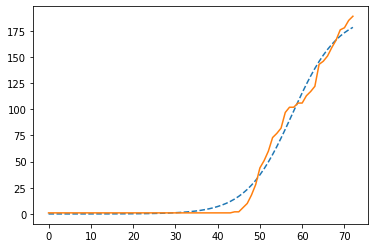

In [34]:
# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_data, y_fitted, '--', label='fitted')
ax.plot(x_data, y_data, label='Confirmed Data')

The growth factor on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.

The growth ratio on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.

In [35]:
# This functions smooths data, thanks to Dan Pearson. We will use it to smooth the data for growth factor
def smoother(inputdata,w,imax):
    data = 1.0*inputdata
    data = data.replace(np.nan,1)
    data = data.replace(np.inf,1)
    #print(data)
    smoothed = 1.0*data
    normalization = 1
    for i in range(-imax,imax+1):
        if i==0:
            continue
        smoothed += (w**abs(i))*data.shift(i,axis=0)
        normalization += w**abs(i)
    smoothed /= normalization
    return smoothed

## Growth Factor

In [36]:
#growth factor
def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    confirmed_iminus2 = confirmed.shift(2, axis=0)
    return (confirmed-confirmed_iminus1)/(confirmed_iminus1-confirmed_iminus2)

In [37]:
w = 0.5
grouped_sl['GrowthFactor'] = growth_factor(grouped_sl['Confirmed'])
grouped_sl['GrowthFactor'] = smoother(grouped_sl['GrowthFactor'],w,5)

In [38]:
# horizontal line at growth rate 1.0 for reference
x_coordinates = [1, 100]
y_coordinates = [1, 1]

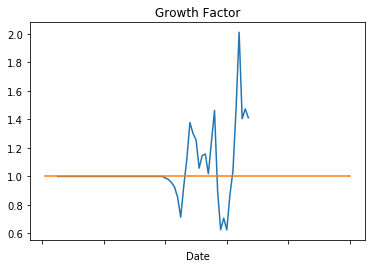

In [39]:
grouped_sl['GrowthFactor'].plot(title='Growth Factor')
plt.plot(x_coordinates, y_coordinates) 
plt.show()

## Growth Ratio

In [41]:
def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

In [43]:
#Plot confirmed[i]/confirmed[i-1], this is called the growth ratio
grouped_sl['GrowthRatio'] = growth_ratio(grouped_sl['Confirmed'])
grouped_sl['GrowthRatio'] = smoother(grouped_sl['GrowthRatio'],w,5)

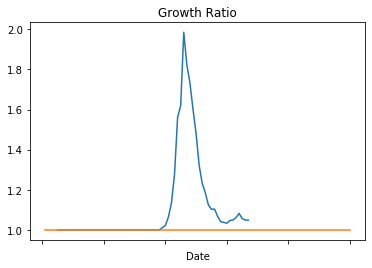

In [44]:
grouped_sl['GrowthRatio'].plot(title='Growth Ratio')
plt.plot(x_coordinates, y_coordinates)
plt.show()

## Growth Rate

In [45]:
#Plot the growth rate, we will define this as k in the logistic function presented at the beginning of this notebook.
grouped_sl['GrowthRate']=np.gradient(np.log(grouped_sl['Confirmed']))
grouped_sl['GrowthRate'] = smoother(grouped_sl['GrowthRate'],0.5,3)

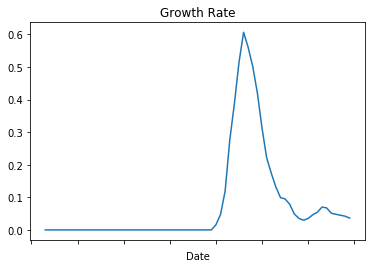

In [47]:
grouped_sl['GrowthRate'].plot(title='Growth Rate')
plt.show()

## 2nd Derivative

In [48]:
# 2nd Derivative
grouped_sl['2nd_Derivative'] = np.gradient(np.gradient(grouped_sl['Confirmed'])) #2nd derivative
grouped_sl['2nd_Derivative'] = smoother(grouped_sl['2nd_Derivative'],w,7)

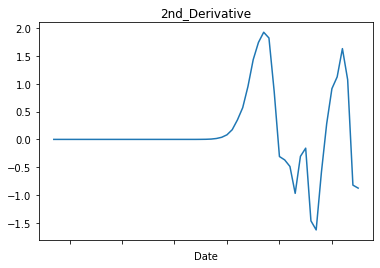

In [49]:
grouped_sl['2nd_Derivative'].plot(title='2nd_Derivative')
plt.show()